In [1]:
import os
import sys
import shutil
os.environ['TOKENIZERS_PARALLELISM'] = "False"

import torch
import pandas as pd
import numpy as np
import decord
import json
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
import PIL.Image
from glob import glob
from natsort import natsorted

from torch.utils.data import Dataset, DataLoader
from easydict import EasyDict as edict
import numpy as np
import json

import shared.utils as su
from utils.video import read_frames_decord
from utils.model import transform_pixel_values
from torchvision.transforms.v2 import (
    ToPILImage,
)
from models.modeling_encoders import AutoEncoder

In [2]:
data_dir = "/scratch/shared/beegfs/piyush/datasets/YouCook2"
video_dir = f"{data_dir}/YouCookIIVideos"
json_path = f"{data_dir}/val.json"
data = su.io.load_json(json_path)
len(data)

3178

In [3]:
data[0]

{'id': 'xHr8X2Wpmno_0',
 'video_url': 'https://www.youtube.com/watch?v=xHr8X2Wpmno',
 'recipe_type': '226',
 'segment': '[47. 60.]',
 'sentence': 'pick the ends off the verdalago',
 'video_path': 'val/xHr8X2Wpmno_0.mp4',
 'youtube_id': 'xHr8X2Wpmno',
 'video': 'val/xHr8X2Wpmno_0.mp4',
 'caption': 'pick the ends off the verdalago'}

In [4]:
import pandas as pd
from collections import defaultdict
import ast

def create_video_dataframe(data: list) -> pd.DataFrame:
    """
    Convert a list of clip entries to a DataFrame where each row is a video.
    """
    video_clips = defaultdict(list)
    
    for clip in data:
        youtube_id = clip['youtube_id']
        clip_id = clip['id']  # e.g., "xHr8X2Wpmno_0"
        
        segment_str = clip['segment']
        segment = ast.literal_eval(segment_str.replace('. ', ', '))
        
        caption = clip.get('caption') or clip.get('sentence')
        
        video_clips[youtube_id].append({
            'clip_id': clip_id,
            'segment': segment,
            'caption': caption
        })
    
    rows = []
    for youtube_id, clips in video_clips.items():
        # Sort clips by start timestamp
        clips_sorted = sorted(clips, key=lambda x: x['segment'][0])
        
        clip_ids = [c['clip_id'] for c in clips_sorted]
        timestamps = [c['segment'] for c in clips_sorted]
        captions = [c['caption'] for c in clips_sorted]
        
        rows.append({
            'youtube_id': youtube_id,
            'clip_ids': clip_ids,
            'timestamps': timestamps,
            'captions': captions
        })
    
    return pd.DataFrame(rows)


df = create_video_dataframe(data)
df.shape

(414, 4)

In [5]:
len(df.iloc[0].timestamps), len(df.iloc[0].captions)

(6, 6)

In [6]:
import random

def sample_segments(df: pd.DataFrame, n_samples: int = 4, seed: int = None) -> pd.DataFrame:
    """
    Sample n non-overlapping segments from each video.
    """
    if seed is not None:
        random.seed(seed)
    
    rows = []
    for _, row in df.iterrows():
        clip_ids = row['clip_ids']
        timestamps = row['timestamps']
        captions = row['captions']
        
        if len(timestamps) < n_samples:
            continue
        
        indices = random.sample(range(len(timestamps)), n_samples)
        indices.sort()
        
        sampled_clip_ids = [clip_ids[i] for i in indices]
        sampled_timestamps = [timestamps[i] for i in indices]
        sampled_captions = [captions[i] for i in indices]
        
        rows.append({
            'youtube_id': row['youtube_id'],
            'clip_ids': sampled_clip_ids,
            'timestamps': sampled_timestamps,
            'captions': sampled_captions
        })
    
    return pd.DataFrame(rows)

In [7]:
subdf = sample_segments(df)
len(subdf.iloc[0].timestamps), len(subdf.iloc[0].captions)

(4, 4)

In [8]:
subdf

youtube_id                                           clip_ids  \
0    xHr8X2Wpmno  [xHr8X2Wpmno_0, xHr8X2Wpmno_1, xHr8X2Wpmno_4, ...   
1    V53XmPeyjIU  [V53XmPeyjIU_0, V53XmPeyjIU_3, V53XmPeyjIU_4, ...   
2    mZwK0TBI1iY  [mZwK0TBI1iY_3, mZwK0TBI1iY_5, mZwK0TBI1iY_6, ...   
3    gEYyWqs1oL0  [gEYyWqs1oL0_0, gEYyWqs1oL0_1, gEYyWqs1oL0_2, ...   
4    fn9anlEL4FI  [fn9anlEL4FI_0, fn9anlEL4FI_4, fn9anlEL4FI_5, ...   
..           ...                                                ...   
397  I1JgU6TK-yc  [I1JgU6TK-yc_1, I1JgU6TK-yc_2, I1JgU6TK-yc_3, ...   
398  3WXM2FAueb8  [3WXM2FAueb8_1, 3WXM2FAueb8_2, 3WXM2FAueb8_4, ...   
399  RY10IUcz3bk  [RY10IUcz3bk_1, RY10IUcz3bk_3, RY10IUcz3bk_4, ...   
400  nuwCjQVlBrg  [nuwCjQVlBrg_3, nuwCjQVlBrg_4, nuwCjQVlBrg_5, ...   
401  oDsUh1es_lo  [oDsUh1es_lo_1, oDsUh1es_lo_2, oDsUh1es_lo_4, ...   

                                            timestamps  \
0    [[47, 60.0], [67, 89.0], [153, 162.0], [163, 1...   
1    [[16, 26.0], [60, 89.0], [93, 103.0], [158, 16...   
2    [[55, 78.0], [96, 102.0], [102, 107.0], [111, ...   
3    [[14, 80.0], [88, 98.0], [103, 126.0], [132, 1...   
4    [[30, 39.0], [230, 238.0], [309, 333.0], [438,...   
..                                                 ...   
397  [[76, 92.0], [103, 121.0], [122, 151.0], [152,...   
398  [[37, 45.0], [47, 65.0], [93, 112.0], [173, 19...   
399  [[117, 149.0], [180, 215.0], [215, 242.0], [24...   
400  [[131, 148.0], [156, 167.0], [243, 275.0], [31...   
401   [[31, 34.0], [37, 41.0], [51, 57.0], [57, 60.0]]   

                                              captions  
0    [pick the ends off the verdalago, combine lemo...  
1    [combine salt butter milk and hot sauce in a b...  
2    [rub flour onto the chicken  dip it in egg and...  
3    [cut the tuna into smaller sections, cut the s...  
4    [add garram masala seeds and a bay leaf to the...  
..                                                 ...  
397  [pour some of it into a cup and put the rest i...  
398  [add salsa and water to the beef, add chili po...  
399  [add cheez whiz and stir, pour macaroni into a...  
400  [remove the skin from the potatos, cut the pot...  
401  [place the bread in the pan, flip the slices o...  

[402 rows x 4 columns]

In [9]:
import torch
import numpy as np
from decord import VideoReader, cpu

def load_frames_from_row(
    row: dict,
    video_dir: str,
    n_frames_per_clip: int = 4,
) -> torch.Tensor:
    """
    Load frames from individual clip videos.
    
    Args:
        row: DataFrame row with 'clip_ids'
        video_dir: Base directory containing clip videos (e.g., "/path/to/test")
        n_frames_per_clip: Number of frames to sample per clip
    
    Returns:
        Tensor of shape (n_clips * n_frames_per_clip, H, W, C), dtype torch.uint8
    """
    clip_ids = row['clip_ids']
    
    all_frames = []
    
    for clip_id in clip_ids:
        # Construct clip video path
        video_path = f"{video_dir}/{clip_id}.mp4"
        
        # Load video
        vr = VideoReader(video_path, ctx=cpu(0))
        n_total_frames = len(vr)
        
        # Sample n_frames_per_clip uniformly across the clip
        frame_indices = np.linspace(0, n_total_frames - 1, n_frames_per_clip, dtype=int)
        
        # Load frames
        frames = vr.get_batch(frame_indices.tolist())  # (n_frames, H, W, C)
        all_frames.append(frames)
    
    # Concatenate: (n_clips * n_frames_per_clip, H, W, C)
    # all_frames = np.concatenate(all_frames, axis=0)
    all_frames = torch.cat(all_frames, dim=0)
    
    # return torch.from_numpy(all_frames).to(torch.uint8)
    return all_frames.to(torch.uint8)


frames = load_frames_from_row(subdf.iloc[0].to_dict(), video_dir = f"{data_dir}/YouCookIIVideos/val")
frames.shape

torch.Size([16, 360, 640, 3])

pick the ends off the verdalago		combine lemon juice sumac garlic salt and oil in a bowl		pour the dressing over the salad and mix		add the fried pita to the salad and mix


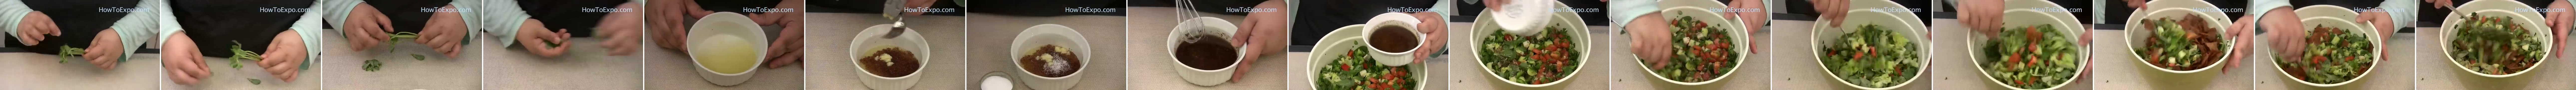

In [10]:
print('\t\t'.join(subdf.iloc[0].to_dict()['captions']))
su.visualize.concat_images_with_border([PIL.Image.fromarray(f.numpy()) for f in frames])

In [11]:
# Load model
from notebooks.eval_care_retrieval import load_model

# model_path = "/work/piyush/pretrained_checkpoints/TARA"
model_path = "/work/piyush/pretrained_checkpoints/Tarsier-7b"
vfc, tfc, vp = load_model(_id=model_path, device_map='auto', n_frames=16)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading CaRe model (/work/piyush/pretrained_checkpoints/Tarsier-7b).............  
Loading EncoderForTarsier from /work/piyush/pretrained_checkpoints/Tarsier-7b
### do_image_padding is set as False, images will be resized directly!


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
TarsierForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
You are attempting to use Flash Attention 2.

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

::: Number of total parameters in TarsierForConditionalGeneration: 7063.427M


In [12]:
from itertools import permutations

def get_caption_permutations(captions: list) -> list:
    """
    Generate all permutations of captions, each joined by '; '.
    
    Args:
        captions: List of caption strings
    
    Returns:
        List of strings, each being a permutation of captions joined by '; '
    """
    return ['; '.join(perm) for perm in permutations(captions)]


joint_captions = get_caption_permutations(subdf.iloc[0].to_dict()['captions'])
joint_captions

['pick the ends off the verdalago; combine lemon juice sumac garlic salt and oil in a bowl; pour the dressing over the salad and mix; add the fried pita to the salad and mix',
 'pick the ends off the verdalago; combine lemon juice sumac garlic salt and oil in a bowl; add the fried pita to the salad and mix; pour the dressing over the salad and mix',
 'pick the ends off the verdalago; pour the dressing over the salad and mix; combine lemon juice sumac garlic salt and oil in a bowl; add the fried pita to the salad and mix',
 'pick the ends off the verdalago; pour the dressing over the salad and mix; add the fried pita to the salad and mix; combine lemon juice sumac garlic salt and oil in a bowl',
 'pick the ends off the verdalago; add the fried pita to the salad and mix; combine lemon juice sumac garlic salt and oil in a bowl; pour the dressing over the salad and mix',
 'pick the ends off the verdalago; add the fried pita to the salad and mix; pour the dressing over the salad and mix; co

In [13]:
tfc(joint_captions[:8]).shape

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


torch.Size([8, 4096])

In [15]:
frames.shape

torch.Size([16, 360, 640, 3])

In [16]:
# Compute video embeddings
zv = torch.nn.functional.normalize(vfc(frames.permute((0, 3, 1, 2))), dim=-1)

# Compute text embeddings for all permutations
zt = torch.nn.functional.normalize(torch.stack([tfc(x) for x in joint_captions]), dim=-1)

zv.shape, zt.shape

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


(torch.Size([4096]), torch.Size([24, 4096]))

In [17]:
sims = []

iterator = su.log.tqdm_iterator(range(len(subdf)))
for i in iterator:
    row = subdf.iloc[i].to_dict()

    try:
        frames = load_frames_from_row(row, video_dir=f"{data_dir}/YouCookIIVideos/val")
        joint_captions = get_caption_permutations(row['captions'])
    
        # Compute video embeddings
        zv = torch.nn.functional.normalize(vfc(frames.permute((0, 3, 1, 2))), dim=-1)
        
        # Compute text embeddings for all permutations
        zt = torch.nn.functional.normalize(torch.stack([tfc(x) for x in joint_captions]), dim=-1)
    
        sims.append(zv @ zt.T)
    except:
        continue

sims = torch.stack(sims)
sims.shape

  0%|          | 0/402 [00:00<?, ?it/s]

[20:12:33] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /scratch/shared/beegfs/piyush/datasets/YouCook2/YouCookIIVideos/val/VH0SmCfAov4_0.mp4, No such file or directory
[h264 @ 0x51fd84c0] mmco: unref short failure
[h264 @ 0x51fd84c0] mmco: unref short failure
[h264 @ 0x5cbfa480] mmco: unref short failure
[h264 @ 0x5cbfa480] mmco: unref short failure
[20:22:17] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /scratch/shared/beegfs/piyush/datasets/YouCook2/YouCookIIVideos/val/10dZTHlkb8w_0.mp4, No such file or directory
[h264 @ 0x526e1940] mmco: unref short failure
[h264 @ 0x526e1940] mmco: unref short failure
[h264 @ 0x5dfa5f80] mmco: unref short failure
[h264 @ 0x5dfa5f80] mmco: unref short failure
[20:26:14] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /scratch/shared/beegfs/piyush/datasets/YouCook2/YouCookIIVideos/val/v_dkYNq8G9Y_2.mp4, No such file or directory
[20:28:03] /github/workspace/src/video/video_reader.cc:83: ERROR openin

torch.Size([389, 24])

In [18]:
(sims.argmax(dim=-1) == 0).sum()

tensor(11)

In [19]:
import numpy as np
import pandas as pd
from math import comb
from scipy.stats import kendalltau, spearmanr

def all_permutations(captions):
    """
    Return list of permutations (tuples) in the same order you'd get from itertools.permutations.
    Useful to map sims indices -> permutation.
    """
    from itertools import permutations
    return list(permutations(range(len(captions))))

def kendall_tau_distance_between_perms(a, b):
    """
    Compute Kendall tau distance (number of discordant pairs) between two permutations a and b.
    a and b should be sequences of the same elements (e.g., 0..K-1) and are permutations.
    Returns integer between 0 and K*(K-1)/2.
    """
    assert len(a) == len(b)
    K = len(a)
    # map element -> position in b
    pos_in_b = {val: i for i, val in enumerate(b)}
    # create array of positions of a's elements in b
    seq = [pos_in_b[val] for val in a]
    # number of inversions in seq is the Kendall distance
    # count inversions (O(K^2) fine for small K; K=4 as in your case)
    inv = 0
    for i in range(K):
        for j in range(i+1, K):
            if seq[i] > seq[j]:
                inv += 1
    return inv

def compute_distance_vector(perms, original_perm):
    """
    perms: list of perms (tuples of indices)
    original_perm: tuple (the original order)
    returns: numpy array of distances (integers)
    """
    dists = np.array([kendall_tau_distance_between_perms(original_perm, p) for p in perms], dtype=int)
    return dists

def dcg_at_k(rels, k):
    """
    rels: list/array of relevance scores (ordered by predicted ranking)
    compute DCG@k using log2 discount (classic)
    """
    rels = np.asarray(rels)[:k]
    if rels.size == 0:
        return 0.0
    discounts = np.log2(np.arange(2, rels.size + 2))  # positions 1.. -> denom log2(2..)
    return np.sum(rels / discounts)

def ndcg_at_k(predicted_indices, relevance_by_index, k):
    """
    predicted_indices: indices in order of predicted ranking (best -> worst)
    relevance_by_index: array-like mapping index -> relevance (higher = better)
    """
    rels_pred = [relevance_by_index[i] for i in predicted_indices[:k]]
    dcg = dcg_at_k(rels_pred, k)
    # ideal DCG: sort relevance descending
    ideal_rels = sorted(relevance_by_index, reverse=True)[:k]
    idcg = dcg_at_k(ideal_rels, k)
    return dcg / idcg if idcg > 0 else 0.0

def reciprocal_rank_of_first_relevant(predicted_indices, relevance_by_index, is_relevant_fn):
    """
    Return reciprocal rank for the first item that satisfies is_relevant_fn(index, relevance).
    If none found, returns 0.
    """
    for rank, idx in enumerate(predicted_indices, start=1):
        if is_relevant_fn(idx, relevance_by_index[idx]):
            return 1.0 / rank
    return 0.0

def compute_ranking_metrics(
    sims_matrix,
    captions,
    perms=None,
    topk_for_recall=(1, 3, 5),
    ndcg_k=10,
):
    """
    sims_matrix: numpy array shape (N, M) where M == factorial(K)
                 higher score = model thinks this permutation is a better caption ordering.
    captions: list of K captions (defines the original order)
    perms: optional list of permutations (tuples of indices). If None, generated from captions order.
    topk_for_recall: iterable of k values to compute Recall@k for the exact original permutation.
    ndcg_k: k used for NDCG@k
    Returns: (per_video_df, aggregate_metrics_dict)
    per_video_df has columns:
      ['kendall_tau', 'spearman_rho', 'mrr', 'recall@k'..., 'ndcg@k', 'orig_perm_index', 'best_pred_index', ...]
    """
    sims = np.asarray(sims_matrix)
    if sims.ndim != 2:
        raise ValueError("sims_matrix must be 2D (N x M)")
    N, M = sims.shape
    K = len(captions)
    from math import factorial
    if M != factorial(K):
        # allow perms list override
        if perms is None:
            raise ValueError(f"sims has M={M} columns but K={K} gives K!={factorial(K)}; pass perms explicitly.")
    # build perms if not given
    if perms is None:
        perms = all_permutations(captions)
    # original_perm is simply (0,1,2,...) representing original order
    original_perm = tuple(range(K))
    dists = compute_distance_vector(perms, original_perm)  # length M
    max_dist = int(dists.max()) if M > 0 else 0
    # define graded relevance: higher relevance when distance smaller
    # shift so relevance >= 0; relevance = max_dist - dist
    relevance = (max_dist - dists).astype(float)

    rows = []
    for vid in range(N):
        sim_row = sims[vid]
        # predicted ranking: indices sorted by decreasing sim (best first)
        pred_order = np.argsort(-sim_row, kind='stable')
        # ground truth ranking: indices sorted by increasing distance (best = distance 0)
        gt_order = np.argsort(dists, kind='stable')
        # convert orders to rank positions (index -> rank position)
        # ranks start at 1 for best
        pred_rank_positions = np.empty(M, dtype=int)
        pred_rank_positions[pred_order] = np.arange(1, M+1)
        gt_rank_positions = np.empty(M, dtype=int)
        gt_rank_positions[gt_order] = np.arange(1, M+1)

        # Kendall and Spearman between the rank position arrays
        # scipy.stats expects two 1D arrays of the same length: use the rank positions
        try:
            kt_stat, kt_p = kendalltau(pred_rank_positions, gt_rank_positions)
            if np.isnan(kt_stat):
                kt_stat = 0.0
        except Exception:
            kt_stat = 0.0

        try:
            sp_stat, sp_p = spearmanr(pred_rank_positions, gt_rank_positions)
            if np.isnan(sp_stat):
                sp_stat = 0.0
        except Exception:
            sp_stat = 0.0

        # MRR & Recall@k for exact original permutation: distance == 0
        # find indices where dists == 0 (there will always be at least one — the original perm)
        orig_indices = np.where(dists == 0)[0]
        # if multiple identically-original permutations (should be exactly 1), we still treat any as relevant
        is_relevant_fn = lambda idx, rel: (dists[idx] == 0)
        mrr = reciprocal_rank_of_first_relevant(pred_order, relevance, is_relevant_fn)
        recalls = {}
        for k in topk_for_recall:
            topk = pred_order[:k]
            recalls[f"recall@{k}"] = int(np.any(dists[topk] == 0))  # 1 if original in top-k else 0

        ndcg = ndcg_at_k(pred_order, relevance, ndcg_k)

        # record which index is best predicted and its distance
        best_pred_idx = int(pred_order[0])
        best_pred_dist = int(dists[best_pred_idx])
        # find rank position of the true original index (if exactly one) — take first
        if orig_indices.size > 0:
            true_idx = int(orig_indices[0])
            true_rank = int(np.where(pred_order == true_idx)[0][0] + 1)
        else:
            true_idx = None
            true_rank = None

        row = {
            "video_index": vid,
            "kendall_tau": kt_stat,
            "spearman_rho": sp_stat,
            "mrr": mrr,
            "ndcg@k": ndcg,
            "best_pred_index": best_pred_idx,
            "best_pred_distance": best_pred_dist,
            "orig_perm_index": int(orig_indices[0]) if orig_indices.size>0 else None,
            "orig_perm_pred_rank": true_rank,
        }
        row.update(recalls)
        rows.append(row)

    df = pd.DataFrame(rows).set_index("video_index")
    # aggregated metrics
    agg = {
        "mean_kendall_tau": float(df["kendall_tau"].mean()),
        "mean_spearman_rho": float(df["spearman_rho"].mean()),
        "mean_mrr": float(df["mrr"].mean()),
        "mean_ndcg@k": float(df["ndcg@k"].mean()),
    }
    for k in topk_for_recall:
        agg[f"mean_recall@{k}"] = float(df[f"recall@{k}"].mean())

    return df, agg


In [20]:
captions = ["c0","c1","c2","c3"]   # original order
from math import factorial
K = len(captions)
M = factorial(K)
# mock: generate sims randomly but bias towards permutations whose Kendall distance is small
perms = all_permutations(captions)


per_video_df, aggregate = compute_ranking_metrics(sims, captions, perms=perms, topk_for_recall=(1,3,5), ndcg_k=5)

print(per_video_df.head())
print("AGG:", aggregate)

             kendall_tau  spearman_rho       mrr    ndcg@k  best_pred_index  \
video_index                                                                   
0              -0.405797     -0.560000  0.062500  0.297068               16   
1              -0.115942     -0.180000  0.058824  0.523960               14   
2               0.420290      0.649565  0.100000  0.633294               11   
3               0.072464      0.003478  0.200000  0.454204               20   
4               0.086957      0.188696  0.250000  0.601657               11   

             best_pred_distance  orig_perm_index  orig_perm_pred_rank  \
video_index                                                             
0                             4                0                   16   
1                             3                0                   17   
2                             4                0                   10   
3                             4                0                    5   
4       

In [21]:
import json
print(json.dumps(aggregate, indent=4))

{
    "mean_kendall_tau": -0.047800007451287214,
    "mean_spearman_rho": -0.06456912931708952,
    "mean_mrr": 0.13343385829596766,
    "mean_ndcg@k": 0.5463544700578762,
    "mean_recall@1": 0.028277634961439587,
    "mean_recall@3": 0.09254498714652956,
    "mean_recall@5": 0.16966580976863754
}


In [2]:
data_dir = "/scratch/shared/beegfs/piyush/datasets/Charades"
df = pd.read_csv(f"{data_dir}/metadata_annotations/Charades_v1_clips_all.csv")
df.shape

(66493, 13)

In [4]:
df

id subject         scene  quality  relevance verified  length  \
0      46GP8    HR43       Kitchen      6.0        7.0      Yes   24.83   
1      46GP8    HR43       Kitchen      6.0        7.0      Yes   24.83   
2      N11GT    0KZ7        Stairs      6.0        7.0      Yes   18.33   
3      N11GT    0KZ7        Stairs      6.0        7.0      Yes   18.33   
4      N11GT    0KZ7        Stairs      6.0        7.0      Yes   18.33   
...      ...     ...           ...      ...        ...      ...     ...   
66488  LSKA2    BONA  Laundry room      7.0        7.0      Yes   29.46   
66489  LSKA2    BONA  Laundry room      7.0        7.0      Yes   29.46   
66490  LSKA2    BONA  Laundry room      7.0        7.0      Yes   29.46   
66491  LSKA2    BONA  Laundry room      7.0        7.0      Yes   29.46   
66492  LSKA2    BONA  Laundry room      7.0        7.0      Yes   29.46   

      cls_id                              cls_name  start_time  end_time  \
0       c092  watching/looking outside of a window        11.9     21.20   
1       c147          someone is cooking something         0.0     12.60   
2       c098                       holding a broom         8.6     14.20   
3       c075                tidying up a blanket/s         0.0     11.70   
4       c127        tidying something on the floor         0.0     15.20   
...      ...                                   ...         ...       ...   
66488   c067                    holding a sandwich        11.0     29.46   
66489   c069      taking a sandwich from somewhere        10.0     19.70   
66490   c061                     holding some food         5.5     29.46   
66491   c097             walking through a doorway        26.8     29.46   
66492   c063            taking food from somewhere        10.1     17.10   

               item_id  split  
0      46GP8_11.9_21.2  train  
1       46GP8_0.0_12.6  train  
2       N11GT_8.6_14.2  train  
3       N11GT_0.0_11.7  train  
4       N11GT_0.0_15.2  train  
...                ...    ...  
66488  LSKA2_11.0_29.5   test  
66489  LSKA2_10.0_19.7   test  
66490   LSKA2_5.5_29.5   test  
66491  LSKA2_26.8_29.5   test  
66492  LSKA2_10.1_17.1   test  

[66493 rows x 13 columns]

In [6]:
df = df[df.split == 'test']
df.shape

(16691, 13)

In [9]:
video_ids = df.id.unique()
for video_id in su.log.tqdm_iterator(video_ids):
    subdf = df[df.id == video_id]
subdf.shape

  0%|          | 0/1814 [00:00<?, ?it/s]

(5, 13)

In [10]:
subdf

id subject         scene  quality  relevance verified  length  \
66488  LSKA2    BONA  Laundry room      7.0        7.0      Yes   29.46   
66489  LSKA2    BONA  Laundry room      7.0        7.0      Yes   29.46   
66490  LSKA2    BONA  Laundry room      7.0        7.0      Yes   29.46   
66491  LSKA2    BONA  Laundry room      7.0        7.0      Yes   29.46   
66492  LSKA2    BONA  Laundry room      7.0        7.0      Yes   29.46   

      cls_id                          cls_name  start_time  end_time  \
66488   c067                holding a sandwich        11.0     29.46   
66489   c069  taking a sandwich from somewhere        10.0     19.70   
66490   c061                 holding some food         5.5     29.46   
66491   c097         walking through a doorway        26.8     29.46   
66492   c063        taking food from somewhere        10.1     17.10   

               item_id split  
66488  LSKA2_11.0_29.5  test  
66489  LSKA2_10.0_19.7  test  
66490   LSKA2_5.5_29.5  test  
66491  LSKA2_26.8_29.5  test  
66492  LSKA2_10.1_17.1  test

In [4]:
df = pd.read_csv(f"{data_dir}/metadata_annotations/Charades_v1_test.csv")
df.shape

(1863, 11)

In [5]:
df.iloc[0].to_dict()

{'id': 'YSKX3',
 'subject': 'CP6Y',
 'scene': 'Bedroom',
 'quality': 5.0,
 'relevance': 6.0,
 'verified': 'Yes',
 'script': 'A person fixes the bed then throws pillow on it.',
 'objects': 'bed;blanket;mattress;pillow',
 'descriptions': 'A person looks under a mattress and pats the bed.  This person picks up a pillow, and throws it on the bed.;A person is in a bedroom.  The person is fixing the bed. After the person cleans up his bed, the person leaves.',
 'actions': 'c077 12.10 18.00;c079 11.80 17.30;c080 13.00 18.00;c076 11.80 17.50;c075 5.40 14.10',
 'length': 16.62}

**$K=4$ events**

In [8]:
df.actions.apply(lambda x: len(str(x).split(";")))

0        5
1       14
2        5
3        4
4       23
        ..
1858     3
1859     9
1860     6
1861     5
1862     5
Name: actions, Length: 1863, dtype: int64

In [9]:
df.descriptions.apply(lambda x: len(str(x).split(". ")))


0       4
1       1
2       1
3       2
4       7
       ..
1858    2
1859    2
1860    1
1861    1
1862    1
Name: descriptions, Length: 1863, dtype: int64